In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import joblib


In [2]:
df = pd.read_csv("../data/processed/diabetes_clean_model_ready.csv")

gb_model = joblib.load("../models/gradient_boosting_model.pkl")

X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

df.shape


(253680, 19)

In [3]:
y_pred = gb_model.predict(X)
y_prob = gb_model.predict_proba(X)[:, 1]

df["predicted_diabetes"] = y_pred
df["predicted_risk"] = y_prob

df[["predicted_diabetes", "predicted_risk"]].head()


,predicted_diabetes,predicted_risk
0,1,0.672652
1,0,0.055875
2,0,0.354344
3,0,0.092416
4,0,0.113088


## FAIRNESS ANALYSIS


In [4]:
sex_pred_rate = df.groupby("Sex")["predicted_diabetes"].mean()
sex_pred_rate


Sex
0.0    0.039127
1.0    0.041672
Name: predicted_diabetes, dtype: float64

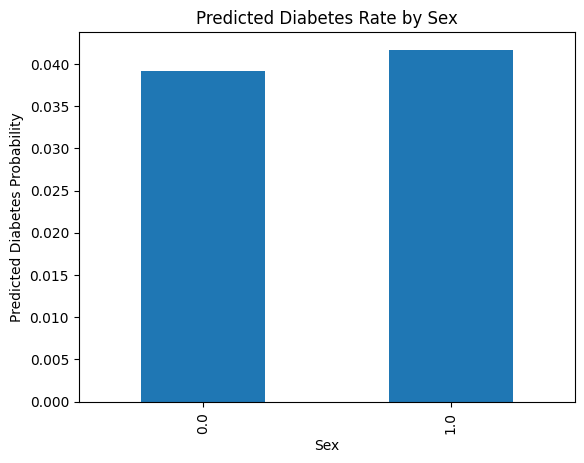

In [5]:
sex_pred_rate.plot(kind="bar", title="Predicted Diabetes Rate by Sex")
plt.ylabel("Predicted Diabetes Probability")
plt.show()


In [6]:
income_pred_rate = df.groupby("Income")["predicted_diabetes"].mean()
income_pred_rate


Income
1.0    0.125369
2.0    0.135534
3.0    0.096411
4.0    0.073603
5.0    0.055017
6.0    0.031725
7.0    0.022328
8.0    0.008995
Name: predicted_diabetes, dtype: float64

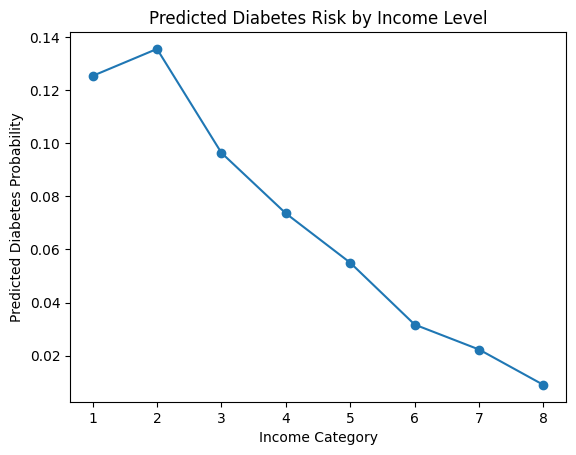

In [7]:
income_pred_rate.plot(
    kind="line", marker="o",
    title="Predicted Diabetes Risk by Income Level"
)
plt.ylabel("Predicted Diabetes Probability")
plt.xlabel("Income Category")
plt.show()


In [8]:
high_risk_threshold = df["predicted_risk"].quantile(0.90)

df["high_risk_flag"] = (df["predicted_risk"] >= high_risk_threshold).astype(int)

df["high_risk_flag"].value_counts(normalize=True)


high_risk_flag
0    0.9
1    0.1
Name: proportion, dtype: float64

In [9]:
high_risk_summary = df[df["high_risk_flag"] == 1][
    ["Sex", "Income", "BMI", "HighBP", "PhysActivity"]
].describe()

high_risk_summary


,Sex,Income,BMI,HighBP,PhysActivity
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,0.474693,4.513797,35.761235,0.951198,0.521799
std,0.499369,2.179214,7.063568,0.215457,0.499534
min,0.000000,1.000000,14.000000,0.000000,0.000000
25%,0.000000,3.000000,31.000000,1.000000,0.000000
50%,0.000000,5.000000,34.000000,1.000000,1.000000
75%,1.000000,6.000000,39.000000,1.000000,1.000000
max,1.000000,8.000000,98.000000,1.000000,1.000000


## ERROR RATE FAIRNESS CHECK


In [10]:
for sex in df["Sex"].unique():
    subset = df[df["Sex"] == sex]
    cm = confusion_matrix(subset["Diabetes_binary"], subset["predicted_diabetes"])
    
    print(f"\nConfusion Matrix for Sex = {sex}")
    print(cm)



Confusion Matrix for Sex = 0.0
[[121203   2360]
 [ 15216   3195]]

Confusion Matrix for Sex = 1.0
[[92823  1948]
 [14228  2707]]


## POLICY SIMULATION


In [11]:
X_policy = X.copy()
X_policy["BMI"] = X_policy["BMI"] - 1

policy_risk = gb_model.predict_proba(X_policy)[:, 1]

df["policy_risk_reduced"] = policy_risk


In [12]:
original_mean_risk = df["predicted_risk"].mean()
policy_mean_risk = df["policy_risk_reduced"].mean()

original_mean_risk, policy_mean_risk, original_mean_risk - policy_mean_risk


(np.float64(0.13930265577715273),
 np.float64(0.13155127163404345),
 np.float64(0.0077513841431092745))

In [13]:
policy_out = df[
    ["predicted_risk", "policy_risk_reduced", "Income", "Sex", "BMI"]
]

policy_out.to_csv("../data/processed/policy_simulation_results.csv", index=False)

"✅ Policy simulation results saved"


'✅ Policy simulation results saved'